### Implementing simple Chatbot Using LangGraph

In [1]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [5]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7133a872ae', 'id': 'chatcmpl-DES34Fn9JK4zmdWMu3q0kSbdETMTw', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019ca781-1786-7c70-b640-b473c1ee54ea-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langchain_groq import ChatGroq

llm_groq=ChatGroq(model="openai/gpt-oss-20b")
llm_groq.invoke("Hey I am Krish and i like to play cricket")

AIMessage(content='Hey Krish! 👋 That’s awesome—cricket’s a fantastic sport. What’s your favorite part about playing it? Are you a bowler, a batsman, or a wicket‑keeper? And which team or player do you root for the most?', additional_kwargs={'reasoning_content': 'The user says "Hey I am Krish and i like to play cricket". They are greeting and telling about their interest. We should respond in friendly manner. The user didn\'t ask a question. We can ask about what they like about cricket, maybe ask about their favorite team or player. We should respond in a friendly tone.'}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 82, 'total_tokens': 212, 'completion_time': 0.135283679, 'completion_tokens_details': {'reasoning_tokens': 67}, 'prompt_time': 0.016291869, 'prompt_tokens_details': None, 'queue_time': 0.015731051, 'total_time': 0.151575548}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_d3e146e1a5', 'service_tier': 'on_demand', 'finish_reas

### We Will start With Creating Nodes

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
def superbot(state:State):
    return {"messages":[llm_groq.invoke(state['messages'])]}

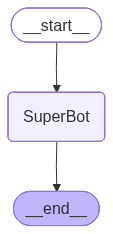

In [8]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [9]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='c13b7640-e624-4e0f-8721-ee374db05734'),
  AIMessage(content='Hello Krish! 👋 It’s great to meet a cricket fan. How can I help you today? Whether you want to chat about the latest matches, learn about a player, or maybe dive into some cricket trivia, I’m all ears!', additional_kwargs={'reasoning_content': 'The user says: "Hi,My name is Krish And I like cricket". We should greet them, ask how to help. Probably respond friendly.'}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 82, 'total_tokens': 173, 'completion_time': 0.107680004, 'completion_tokens_details': {'reasoning_tokens': 32}, 'prompt_time': 0.00400874, 'prompt_tokens_details': None, 'queue_time': 0.015397378, 'total_time': 0.111688744}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_9b8528b477', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': 

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

<!-- ![image.png](attachment:image.png) -->

In [21]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config=config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hey Krish! 👋  \nIt’s great to meet you. I see you’re a cricket fan—what’s your favorite part of the game?  \n\n- Do you follow the IPL, international Tests/ODIs/T20s, or a particular national team?  \n- Got a favorite player or team?  \n- Or maybe you enjoy playing cricket yourself?  \n\nLet me know what excites you most, and we can dive into recent highlights, stats, or any cricket trivia you’re curious about! 🏏', additional_kwargs={'reasoning_content': 'User keeps repeating same phrase. Likely wants to start conversation. We should respond acknowledging and ask about cricket. Possibly mention football too? But user repeated. We should respond politely, ask what they like.'}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 1872, 'total_tokens': 2028, 'completion_time': 0.180347563, 'completion_tokens_details': {'reasoning_tokens': 42}, 'prompt_time': 0.11084727, 'prompt_tokens_details': None, 'queue_time': 0.0

In [24]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='ad1ca949-9752-4262-8170-03b50f08e508'), AIMessage(content="Hey Krish! 👋 It's great to meet a fellow cricket fan. Do you follow any particular team or player? Or maybe you enjoy playing on the field yourself? Whatever your interest, I'm here to chat about it!", additional_kwargs={'reasoning_content': 'User: "Hi, My name is Krish And I like cricket". We need to respond friendly. There\'s no request. Just greeting. We can respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 82, 'total_tokens': 170, 'completion_time': 0.106015282, 'completion_tokens_details': {'reasoning_tokens': 34}, 'prompt_time': 0.003957686, 'prompt_tokens_details': None, 'queue_time': 0.016464651, 'total_time': 0.109972968}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_ef00694abe', 'service_tier': 'on_demand', 'finish_reason': 'sto

In [25]:
for chunk in graph_builder.stream({'messages':"I also like football "},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hey Krish! 👋  \nIt’s awesome to meet a fellow fan of both cricket and football. 🎉\n\nWhat’s your favorite part of each sport?  \n- **Cricket** – Are you into the IPL, the international Test/ODI/T20 series, or maybe a particular national team?  \n- **Football** – Do you follow the Premier League, La\u202fLiga, Serie\u202fA, or a local club?  \n\nIf you’re into playing, do you hit the field or the pitch on weekends?  \nOr maybe you’re just looking for the latest highlights, stats, or some fun trivia?  \n\nLet me know what’s got you excited, and we can dive into the details! ⚽️🏏', additional_kwargs={'reasoning_content': 'The user is repeating the same statements. They say they like cricket and football. They want to talk about it. The user hasn\'t asked a question. We can respond with a friendly conversation, ask them what they like. The policy: no disallowed content. It\'s safe. We can comply.\n\nWe can ask: "What do you like about cricket? W

In [26]:
for chunk in graph_builder.stream({'messages':"I Love sports "},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='ad1ca949-9752-4262-8170-03b50f08e508'), AIMessage(content="Hey Krish! 👋 It's great to meet a fellow cricket fan. Do you follow any particular team or player? Or maybe you enjoy playing on the field yourself? Whatever your interest, I'm here to chat about it!", additional_kwargs={'reasoning_content': 'User: "Hi, My name is Krish And I like cricket". We need to respond friendly. There\'s no request. Just greeting. We can respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 82, 'total_tokens': 170, 'completion_time': 0.106015282, 'completion_tokens_details': {'reasoning_tokens': 34}, 'prompt_time': 0.003957686, 'prompt_tokens_details': None, 'queue_time': 0.016464651, 'total_time': 0.109972968}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_ef00694abe', 'service_tier': 'on_demand', 'finish_reason': 'sto

#### Streaming The Responses With astream Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [27]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019ca792-83e9-7203-aecf-dc6cef294786', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='ad1ca949-9752-4262-8170-03b50f08e508'), AIMessage(content="Hey Krish! 👋 It's great to meet a fellow cricket fan. Do you follow any particular team or player? Or maybe you enjoy playing on the field yourself? Whatever your interest, I'm here to chat about it!", additional_kwargs={'reasoning_content': 'User: "Hi, My name is Krish And I like cricket". We need to respond friendly. There\'s no request. Just greeting. We can respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 82, 'total_tokens': 170, 'completion_time': 0.106015282, 'c